# FIU DATA ATTATCH

In [ ]:
import numpy as np
import os

path = "./data/crawl_frag"
fiu_list = []

for file in os.listdir(path):
    if file.startswith("fiu"):
        fiu_list.append(np.load(path+file))

In [ ]:
fiu_array = np.concatenate(fiu_list, 0)

In [ ]:
np.save("./fiu_data.npy", fiu_array)

# Typeface Dict ATTATCH

In [96]:
import numpy as np
import os
import urllib.request

path = "../data/crawl_frag/"
type_list = []

for file in os.listdir(path):
    if file.startswith("typeface"):
        type_list.append(np.load(path+file).item())

In [97]:
new_type_dict = {}
for dic in type_list:
    for (key, value) in dic.items():
        if new_type_dict.get(key) == None:
            new_type_dict[key] = value
        else:
            continue

In [47]:
import urllib.request
dw_path = "../data/png/"

for (name, url) in new_type_dict.items():
    name = name.replace(' ','%').replace('/','=')
    urllib.request.urlretrieve(url, dw_path+name+".png")

indexing again

In [102]:
import urllib.request
dw_path = "../data/idx_png/"
typo2id = np.load("../data/typo_dict.npy").item()

for (name, url) in new_type_dict.items():
    name = str(typo2id[name])
    urllib.request.urlretrieve(url, dw_path+name+".png")

# FastText

In [ ]:
import io
fin = io.open("../data/word_emb/wiki-news-300d-1M.vec", 
              'r', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(int, fin.readline().split())

In [ ]:
ft_dict = {'u*n*k':0, 'p*a*d':1}
ft_list = ['u*n*k', 'p*a*d']

word2vec = {}
for line in fin:
    tokens = line.rstrip().split(' ')
    word2vec[tokens[0]] = list(map(float, tokens[1:]))
    ft_dict[tokens[0]] = len(ft_list)
    ft_list.append(tokens[0])

np.save('ft_w2v.npy', word2vec)
np.save('ft_w2i.npy', ft_dict)
np.save('ft_i2w.npy', ft_list)

In [ ]:
ft_list = np.load('../data/word_emb/ft_i2w.npy')
word2vec = np.load('../data/word_emb/ft_w2v.npy').item()
print(len(ft_list), ft_list[0], ft_list[1])

In [ ]:
ft_i2v = []
for word in ft_list[2:]:
    ft_i2v.append(word2vec[word])
ft_i2v = np.array(ft_i2v)
np.save("../data/word_emb/ft_i2v.npy", ft_i2v)

In [ ]:
ft_i2v.shape

# Glove

In [24]:
glove = open("../data/word_emb/glove.6B.300d.txt")
gb_dict = {'u*n*k':0, 'p*a*d':1}
gb_list = ['u*n*k', 'p*a*d']
word2vec = {}

In [25]:
for line in glove:
    tokens = line.split(" ")
    word = tokens[0]
    vec  = list(map(float, tokens[1:]))
    word2vec[word] = vec
    gb_dict[tokens[0]] = len(gb_list)
    gb_list.append(tokens[0])

np.save('../data/word_emb/gb_w2v.npy', word2vec)
np.save('../data/word_emb/gb_w2i.npy', gb_dict)
np.save('../data/word_emb/gb_i2w.npy', gb_list)

In [30]:
gb_i2v = []
for word in gb_list[2:]:
    gb_i2v.append(word2vec[word])
gb_i2v = np.array(gb_i2v)
np.save("../data/word_emb/gb_i2v.npy", gb_i2v)

# typo2id

In [84]:
import numpy
data = np.load('../data/fiu_data.npy')

In [85]:
typo2id={}
id2typo=[]

for tokens in data:
    typos = tokens[0]
    for typo in typos:
        if typo2id.get(typo) == None:
            typo2id[typo] = len(id2typo)
            id2typo.append(typo)

np.save('../data/typo_list.npy', id2typo)
np.save('../data/typo_dict.npy', typo2id)

# MAKE DATA : Each Typo for an Indexed Text

In [93]:
import nltk
#nltk.download('punkt')
import numpy as np
data_arr = np.load("../data/fiu_data.npy")
ft_dict = np.load("../data/word_emb/gb_w2i.npy").item()
typo2id = np.load("../data/typo_dict.npy").item()

In [94]:
UNK = 0
PAD = 1

new_data = []
idx2typos = []
idx2text = []

for i, (typo_list, text) in enumerate(data_arr):
    sent_text = nltk.sent_tokenize(text.lower())
    text = [[word for word in nltk.word_tokenize(sentence)] for sentence in sent_text]
    text = [a for b in text for a in b]
    
    indexed_text = []
    for word in text:
        if ft_dict.get(word) != None:
            indexed_text.append(ft_dict[word])
        else:
            indexed_text.append(UNK)
    
    # cutting till 300 words
    if len(indexed_text) > 300:
        sent_len = 300
        indexed_text = indexed_text[:300]
    elif len(indexed_text) < 300:
        sent_len = len(indexed_text)
        indexed_text += [PAD]*(300-len(indexed_text))

    for typo in typo_list:
        new_data.append([i] + [typo2id[typo]])
        
    idx2text.append(indexed_text + [sent_len])
    idx2typos.append([typo2id[typo] for typo in typo_list])
        
np.save('../data/fiu_indexed.npy', new_data)
np.save('../data/idx2typos.npy', idx2typos)
np.save('../data/idx2text.npy', idx2text)

# Graph

In [74]:
import numpy as np
data = np.load("../data/fiu_indexed.npy")
idx2typo = np.load('../data/idx2typos.npy').item()
typo_dict = np.load("../data/typo_dict.npy").item()
typo_list = np.load('../data/typo_list.npy')

In [59]:
text_len = len(idx2typo)
typo_len = len(typo_list)
graph_matrix = np.zeros((text_len, typo_len))

for (text_idx, typos) in idx2typo.items():
    for typo in typos:
        try:
            typo_idx = typo_dict[typo.replace('_',' ').replace('=','/')]
        except KeyError:
            typo_idx = typo_dict[typo]
        graph_matrix[text_idx, typo_idx] += 1

In [65]:
typo2typo_mat = np.zeros((typo_len, typo_len))

for (_, typos) in idx2typo.items():
    for typo1 in typos:
        try:
            typo1_idx = typo_dict[typo1.replace('_',' ').replace('=','/')]
        except KeyError:
            typo1_idx = typo_dict[typo1]
            
        for typo2 in typos:
            try:
                typo2_idx = typo_dict[typo2.replace('_',' ').replace('=','/')]
            except KeyError:
                typo2_idx = typo_dict[typo2]
                
            typo2typo_mat[typo1_idx, typo2_idx] += 1

In [73]:
np.save('../data/text2typo_mat.npy', graph_matrix)
np.save('../data/typo2typo_mat.npy', typo2typo_mat)

# Statistics

In [ ]:
text_len = []
for (typo, text) in new_data:
    text_len.append(len(text))
print(np.max(text_len), np.mean(text_len), np.median(text_len), np.min(text_len))
print(len(new_data))

In [12]:
from os import listdir
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np

image_path = "../data/png/"
file_list = listdir(image_path)

(32, 256)


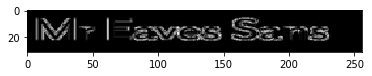

In [35]:
max_w = 0
max_h = 1

for file in file_list:
    im = Image.open(image_path+file, 'r').convert("L")
    w, h = im.size
    
    if max_w < w:
        max_w = w
    if max_h < h:
        max_h = h
        
    im = im.resize((256,32), Image.ANTIALIAS)
    print(np.asarray(im).shape)
    imshow(np.asarray(im), cmap='gray')
    break
#print(max_w, max_h)

In [107]:
max([len(lst) for lst in idx2typos])

29